# Healthcare Case Studies - Final

In [32]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import metrics

<a id="dataClean"></a>
<div>
    <h1>
        Data Cleaning
    </h1> 
</div>

## Data Import

In [2]:
claims = pd.read_csv("uopjan16_claims_in.csv", dtype={'ndc': str})
rx = pd.read_csv("uopjanref_rx_lookup.csv", dtype={"National Drug Code":str})
rx['National Drug Code'] = rx['National Drug Code'].str.zfill(11)
enroll = pd.read_csv("uopjan16_enroll_in.csv")

Next we will clean the data. We will start by combining all input files into one, cutting out all the extra features we don't need. Once that's done, we will peform an aggregate operation to get the counts of AC and AD medicatins. Then we will deal with NA values appropriately, and finally, we will peform the final operations, which is to rename and move columns and add a derived column

<a id="wrangling"></a>
<div>
    <h2>
        Data Wrangling
    </h2> 
</div>

First we will get rid of unnecessary columns

In [3]:
claimsCols = claims[["pat_id", "ndc", 'from_dt', 'rec_spec', 'rectype','pos','DAYSSUP', 
                     'diag1', 'diag2', 'diag3', 'diag4']]
enrollCols = enroll[["pat_id", "der_sex", "der_yob"]]
rxCols = rx[["National Drug Code", "rx_group"]]

Next, we will join the data to one dataframe and drop the `ndc`. We will also replace all N/A values with "Not Specified"

In [4]:
claimsEnroll = pd.merge(claimsCols, enrollCols, on="pat_id", how='outer')
claimsEnrollRx = pd.merge(claimsEnroll, rxCols, left_on="ndc"
                    , right_on="National Drug Code", how='outer').drop(['ndc', 'National Drug Code'], axis=1)
combined = claimsEnrollRx.fillna("Not Specified")
print(combined.shape)
combined.head()

(1788544, 13)


,pat_id,from_dt,rec_spec,rectype,pos,DAYSSUP,diag1,diag2,diag3,diag4,der_sex,der_yob,rx_group
0,0309AAAAAAAATOHM,2011-08-03,Not Specified,P,00,90,Not Specified,Not Specified,Not Specified,Not Specified,M,1949,ANTIDIABETICS
1,0309AAAAAAAATOHM,2011-11-21,Not Specified,P,00,90,Not Specified,Not Specified,Not Specified,Not Specified,M,1949,ANTIDIABETICS
2,0309AAAAAAAATOHM,2012-02-22,Not Specified,P,00,90,Not Specified,Not Specified,Not Specified,Not Specified,M,1949,ANTIDIABETICS
3,0309AAAAAAAATOHM,2012-05-09,Not Specified,P,00,90,Not Specified,Not Specified,Not Specified,Not Specified,M,1949,ANTIDIABETICS
4,0309AAAAAAAATOHM,2012-08-06,Not Specified,P,00,90,Not Specified,Not Specified,Not Specified,Not Specified,M,1949,ANTIDIABETICS


We will filter out dates between the index period, as this will allow us to calculate the index date for each patient.

In [5]:
combinedDateFiltered =  combined[((combined['from_dt'] >= '2013-01-01') & (combined['from_dt'] <= '2013-03-31')) 
               & ((combined['rx_group'] == 'ANTIDIABETICS') | (combined['rx_group'] == 'ANTICOAGULANTS'))]
print(combinedDateFiltered.shape)
combinedDateFiltered.head()

(16703, 13)


,pat_id,from_dt,rec_spec,rectype,pos,DAYSSUP,diag1,diag2,diag3,diag4,der_sex,der_yob,rx_group
6,0309AAAAAAAATOHM,2013-02-03,Not Specified,P,00,90,Not Specified,Not Specified,Not Specified,Not Specified,M,1949,ANTIDIABETICS
18,s124AAAAAHRWNPCB,2013-03-15,Not Specified,P,00,90,Not Specified,Not Specified,Not Specified,Not Specified,F,1947,ANTIDIABETICS
1076342,h214AAAAAAFXQVOO,2013-01-07,INTERN,P,00,30,Not Specified,Not Specified,Not Specified,Not Specified,M,1951,ANTIDIABETICS
1076343,h214AAAAAAFXQVOO,2013-02-06,INTERN,P,00,30,Not Specified,Not Specified,Not Specified,Not Specified,M,1951,ANTIDIABETICS
1076344,h214AAAAAAFXQVOO,2013-03-11,INTERN,P,00,30,Not Specified,Not Specified,Not Specified,Not Specified,M,1951,ANTIDIABETICS


We'll get the index date for each patient and store it in the `patientIndexDate` DataFrame

In [6]:
combinedFilteredSorted = combinedDateFiltered.sort_values(by=['pat_id', 'from_dt'])
patientIndexDate = combinedFilteredSorted.drop_duplicates(['pat_id'])[["pat_id", 'from_dt']]
patientIndexDate['pre_index'] = pd.to_datetime(patientIndexDate.from_dt) - pd.to_timedelta(180, unit='d')
patientIndexDate['post_index'] = pd.to_datetime(patientIndexDate.from_dt) + pd.to_timedelta(180, unit='d')
patientIndexDate = patientIndexDate.rename(columns={"from_dt": "index_date"})
patientIndexDate.head()

,pat_id,index_date,pre_index,post_index
6,0309AAAAAAAATOHM,2013-02-03,2012-08-07,2013-08-02
1076632,0309AAAAAAAEEDAZ,2013-01-05,2012-07-09,2013-07-04
1092901,0309AAAAAAAFHCZL,2013-02-10,2012-08-14,2013-08-09
1097669,0309AAAAAAAFZJWC,2013-01-18,2012-07-22,2013-07-17
1115651,0309AAAAAAAIFEJH,2013-01-07,2012-07-11,2013-07-06


We see which patients are taking Antidiabetics and Anticoagulants and mark them down. 

In [7]:
combinedDateFilteredAC = combinedDateFiltered[combinedDateFiltered['rx_group']=='ANTICOAGULANTS'].drop(['from_dt', 'rec_spec', 'der_sex', 'der_yob', 'DAYSSUP','diag1', 'diag2', 'diag3', 'diag4','rectype','pos'], axis=1)
combinedDateFilteredAC['rx_group']=1
combinedDateFilteredAC=combinedDateFilteredAC.rename(columns={'rx_group':'RX_ANTICOGULANTS'}).drop_duplicates(['pat_id'])
print(combinedDateFilteredAC.shape)
combinedDateFilteredAC.head()

(930, 2)


,pat_id,RX_ANTICOGULANTS
1106185,0309AAAAAAALOFMS,1
1106189,0309AAAAAAAUWGTK,1
1106212,0309AAAAAABIXTCA,1
1106229,0309AAAAAABJGLZU,1
1106232,0309AAAAAABTXLZS,1


In [8]:
combinedDateFilteredAD = combinedDateFiltered[combinedDateFiltered['rx_group']=='ANTIDIABETICS'].drop(['from_dt', 'rec_spec', 'der_sex', 'der_yob', 'DAYSSUP', 'diag1', 'diag2', 'diag3', 'diag4','rectype','pos'], axis=1)
combinedDateFilteredAD['rx_group']=1
combinedDateFilteredAD=combinedDateFilteredAD.rename(columns={'rx_group':'RX_ANTIDIABETICS'}).drop_duplicates(['pat_id'])
print(combinedDateFilteredAD.shape)
combinedDateFilteredAD.head()

(5076, 2)


,pat_id,RX_ANTIDIABETICS
6,0309AAAAAAAATOHM,1
18,s124AAAAAHRWNPCB,1
1076342,h214AAAAAAFXQVOO,1
1076632,0309AAAAAAAEEDAZ,1
1076644,0309AAAAAAALOFMS,1


### Now we will start making the extraction file

In [9]:
extractionFile = pd.merge(enrollCols, patientIndexDate, on='pat_id', how='outer')
extractionFile = pd.merge(extractionFile, combinedDateFilteredAC, on='pat_id', how='outer')
extractionFile = pd.merge(extractionFile, combinedDateFilteredAD, on='pat_id', how='outer')
extractionFile.head()

,pat_id,der_sex,der_yob,index_date,pre_index,post_index,RX_ANTICOGULANTS,RX_ANTIDIABETICS
0,0309AAAAAAAATOHM,M,1949.0,2013-02-03,2012-08-07,2013-08-02,NaN,1.0
1,0309AAAAAAAEEDAZ,F,1944.0,2013-01-05,2012-07-09,2013-07-04,NaN,1.0
2,0309AAAAAAAFHCZL,M,1932.0,2013-02-10,2012-08-14,2013-08-09,NaN,1.0
3,0309AAAAAAAFZJWC,M,1943.0,2013-01-18,2012-07-22,2013-07-17,NaN,1.0
4,0309AAAAAAAIFEJH,F,1961.0,2013-01-07,2012-07-11,2013-07-06,NaN,1.0


### Now we will work on the pre index characteristics

First, we need to filter out the claims to only analyze pre index date range, so we add the index date to the combined dataframe with all the data to start slicing it.

In [10]:
combinedIndexes = pd.merge(combined, patientIndexDate, on='pat_id', how = 'outer')
combinedIndexes.from_dt = pd.to_datetime(combinedIndexes.from_dt)
combinedIndexes.index_date = pd.to_datetime(combinedIndexes.index_date)
combinedIndexes.head()

,pat_id,from_dt,rec_spec,rectype,pos,DAYSSUP,diag1,diag2,diag3,diag4,der_sex,der_yob,rx_group,index_date,pre_index,post_index
0,0309AAAAAAAATOHM,2011-08-03,Not Specified,P,00,90,Not Specified,Not Specified,Not Specified,Not Specified,M,1949,ANTIDIABETICS,2013-02-03,2012-08-07,2013-08-02
1,0309AAAAAAAATOHM,2011-11-21,Not Specified,P,00,90,Not Specified,Not Specified,Not Specified,Not Specified,M,1949,ANTIDIABETICS,2013-02-03,2012-08-07,2013-08-02
2,0309AAAAAAAATOHM,2012-02-22,Not Specified,P,00,90,Not Specified,Not Specified,Not Specified,Not Specified,M,1949,ANTIDIABETICS,2013-02-03,2012-08-07,2013-08-02
3,0309AAAAAAAATOHM,2012-05-09,Not Specified,P,00,90,Not Specified,Not Specified,Not Specified,Not Specified,M,1949,ANTIDIABETICS,2013-02-03,2012-08-07,2013-08-02
4,0309AAAAAAAATOHM,2012-08-06,Not Specified,P,00,90,Not Specified,Not Specified,Not Specified,Not Specified,M,1949,ANTIDIABETICS,2013-02-03,2012-08-07,2013-08-02


Once we get the index dates on the combined DF, we will filter the dataframe to only include claims in the pre index period for each patient.

In [11]:
preCombinedIndexes = combinedIndexes[(combinedIndexes["from_dt"] <= combinedIndexes["index_date"]) & 
                                 (combinedIndexes["from_dt"] >= combinedIndexes["pre_index"])]
preCombinedIndexes = preCombinedIndexes.drop(['diag1', 'diag2', 'diag3', 'diag4'], axis=1)
print(preCombinedIndexes.shape)
preCombinedIndexes.head()

(353618, 12)


,pat_id,from_dt,rec_spec,rectype,pos,DAYSSUP,der_sex,der_yob,rx_group,index_date,pre_index,post_index
5,0309AAAAAAAATOHM,2012-11-02,Not Specified,P,00,90,M,1949,ANTIDIABETICS,2013-02-03,2012-08-07,2013-08-02
6,0309AAAAAAAATOHM,2013-02-03,Not Specified,P,00,90,M,1949,ANTIDIABETICS,2013-02-03,2012-08-07,2013-08-02
17,0309AAAAAAAATOHM,2012-10-30,Not Specified,P,00,90,M,1949,BETA BLOCKERS,2013-02-03,2012-08-07,2013-08-02
18,0309AAAAAAAATOHM,2013-01-26,Not Specified,P,00,90,M,1949,BETA BLOCKERS,2013-02-03,2012-08-07,2013-08-02
28,0309AAAAAAAATOHM,2012-08-16,Not Specified,P,00,90,M,1949,ANTIHYPERLIPIDEMICS,2013-02-03,2012-08-07,2013-08-02


Now we will calculate which patients had a pre index period cardiology visit

In [12]:
patientsCardiol = preCombinedIndexes[(preCombinedIndexes['rec_spec'] == 'CARDIOL') 
                                     & (preCombinedIndexes['rectype'] == 'M') 
                                     & (preCombinedIndexes['pos'] == '11')].drop_duplicates(['pat_id'])
patientsCardiol['pre_CARDIOL'] = 1
patientsCardiol = patientsCardiol[['pat_id', 'pre_CARDIOL']]
print(patientsCardiol.shape)
patientsCardiol.head()

(856, 2)


,pat_id,pre_CARDIOL
120,0309AAAAAAAATOHM,1
455,0309AAAAAAEJMQNZ,1
857,0309AAAAAAEPXXQA,1
1319,0309AAAAAAFLAMMZ,1
1951,0360AAAAAANYINGD,1


And then we will calculate how many AntiHyperintensives each patient was prescribed during the pre index period

In [13]:
preCombinedIndexesAH = preCombinedIndexes[preCombinedIndexes['rx_group']=='ANTIHYPERTENSIVES']
preCombinedAHAGG = preCombinedIndexesAH.groupby(['pat_id'], as_index=False)['rx_group'].count()
preCombinedAHAGG = preCombinedAHAGG.rename(columns={'rx_group':'Pre_ANTIHYPERINTENSIVES'})
preCombinedAHAGG.head()

,pat_id,Pre_ANTIHYPERINTENSIVES
0,0309AAAAAAAATOHM,2
1,0309AAAAAAAFHCZL,2
2,0309AAAAAAAFZJWC,5
3,0309AAAAAAAIFEJH,6
4,0309AAAAAAAKFIHG,2


In [14]:
combinedIndexes[combinedIndexes['rx_group']=='ANTIHYPERTENSIVES']


,pat_id,from_dt,rec_spec,rectype,pos,DAYSSUP,diag1,diag2,diag3,diag4,der_sex,der_yob,rx_group,index_date,pre_index,post_index
34,0309AAAAAAAATOHM,2011-09-21,Not Specified,P,00,90,Not Specified,Not Specified,Not Specified,Not Specified,M,1949,ANTIHYPERTENSIVES,2013-02-03,2012-08-07,2013-08-02
35,0309AAAAAAAATOHM,2011-12-20,Not Specified,P,00,90,Not Specified,Not Specified,Not Specified,Not Specified,M,1949,ANTIHYPERTENSIVES,2013-02-03,2012-08-07,2013-08-02
36,0309AAAAAAAATOHM,2012-03-17,Not Specified,P,00,90,Not Specified,Not Specified,Not Specified,Not Specified,M,1949,ANTIHYPERTENSIVES,2013-02-03,2012-08-07,2013-08-02
37,0309AAAAAAAATOHM,2012-06-15,Not Specified,P,00,90,Not Specified,Not Specified,Not Specified,Not Specified,M,1949,ANTIHYPERTENSIVES,2013-02-03,2012-08-07,2013-08-02
38,0309AAAAAAAATOHM,2012-09-12,Not Specified,P,00,90,Not Specified,Not Specified,Not Specified,Not Specified,M,1949,ANTIHYPERTENSIVES,2013-02-03,2012-08-07,2013-08-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1788519,s111AAAAACOKFCXO,2013-06-03,Not Specified,P,00,30,Not Specified,Not Specified,Not Specified,Not Specified,F,1933,ANTIHYPERTENSIVES,2013-01-07,2012-07-11,2013-07-06
1788520,s111AAAAACOKFCXO,2013-07-16,Not Specified,P,00,30,Not Specified,Not Specified,Not Specified,Not Specified,F,1933,ANTIHYPERTENSIVES,2013-01-07,2012-07-11,2013-07-06
1788521,s111AAAAACOKFCXO,2013-08-20,Not Specified,P,00,30,Not Specified,Not Specified,Not Specified,Not Specified,F,1933,ANTIHYPERTENSIVES,2013-01-07,2012-07-11,2013-07-06
1788522,s111AAAAACOKFCXO,2013-09-16,Not Specified,P,00,90,Not Specified,Not Specified,Not Specified,Not Specified,F,1933,ANTIHYPERTENSIVES,2013-01-07,2012-07-11,2013-07-06


### Update Extraction File

We will now update the extraction file with the pre index information

In [15]:
extractionFile = pd.merge(extractionFile, patientsCardiol, on="pat_id", how='outer')
extractionFile = pd.merge(extractionFile, preCombinedAHAGG, on="pat_id", how='outer')

In [16]:
extractionFile.head()

,pat_id,der_sex,der_yob,index_date,pre_index,post_index,RX_ANTICOGULANTS,RX_ANTIDIABETICS,pre_CARDIOL,Pre_ANTIHYPERINTENSIVES
0,0309AAAAAAAATOHM,M,1949.0,2013-02-03,2012-08-07,2013-08-02,NaN,1.0,1.0,2.0
1,0309AAAAAAAEEDAZ,F,1944.0,2013-01-05,2012-07-09,2013-07-04,NaN,1.0,NaN,NaN
2,0309AAAAAAAFHCZL,M,1932.0,2013-02-10,2012-08-14,2013-08-09,NaN,1.0,NaN,2.0
3,0309AAAAAAAFZJWC,M,1943.0,2013-01-18,2012-07-22,2013-07-17,NaN,1.0,1.0,5.0
4,0309AAAAAAAIFEJH,F,1961.0,2013-01-07,2012-07-11,2013-07-06,NaN,1.0,NaN,6.0


### Now we will work on the post index characteristics

First we filter out to only include post index claims for patients

In [17]:
postCombinedIndexes = combinedIndexes[(combinedIndexes["from_dt"] >= combinedIndexes["index_date"]) & 
                                 (combinedIndexes["from_dt"] <= combinedIndexes["post_index"])]
print(postCombinedIndexes.shape)
postCombinedIndexes.head()

(359090, 16)


,pat_id,from_dt,rec_spec,rectype,pos,DAYSSUP,diag1,diag2,diag3,diag4,der_sex,der_yob,rx_group,index_date,pre_index,post_index
6,0309AAAAAAAATOHM,2013-02-03,Not Specified,P,00,90,Not Specified,Not Specified,Not Specified,Not Specified,M,1949,ANTIDIABETICS,2013-02-03,2012-08-07,2013-08-02
7,0309AAAAAAAATOHM,2013-05-01,Not Specified,P,00,90,Not Specified,Not Specified,Not Specified,Not Specified,M,1949,ANTIDIABETICS,2013-02-03,2012-08-07,2013-08-02
8,0309AAAAAAAATOHM,2013-07-29,Not Specified,P,00,90,Not Specified,Not Specified,Not Specified,Not Specified,M,1949,ANTIDIABETICS,2013-02-03,2012-08-07,2013-08-02
19,0309AAAAAAAATOHM,2013-04-26,Not Specified,P,00,90,Not Specified,Not Specified,Not Specified,Not Specified,M,1949,BETA BLOCKERS,2013-02-03,2012-08-07,2013-08-02
20,0309AAAAAAAATOHM,2013-07-22,Not Specified,P,00,90,Not Specified,Not Specified,Not Specified,Not Specified,M,1949,BETA BLOCKERS,2013-02-03,2012-08-07,2013-08-02


Them we get the aggregated count of Anticoagulants and Antidiabetic prescriptions during the post index period for each patient

In [18]:
postCombinedIDXACAD = postCombinedIndexes[(postCombinedIndexes['rx_group']=='ANTICOAGULANTS') | (postCombinedIndexes['rx_group']=='ANTIDIABETICS')][['pat_id','rx_group']]
postCombinedIDXACADAgg = postCombinedIDXACAD.groupby(['pat_id', 'rx_group']).size().unstack().fillna(0).reset_index()
postCombinedIDXACADAgg = postCombinedIDXACADAgg.rename(columns={"ANTICOAGULANTS":'POST_ANTICOAGULANTS', 'ANTIDIABETICS':'POST_ANTIDIABETICS'}) 
postCombinedIDXACADAgg.head()

rx_group,pat_id,POST_ANTICOAGULANTS,POST_ANTIDIABETICS
0,0309AAAAAAAATOHM,0.0,3.0
1,0309AAAAAAAEEDAZ,0.0,7.0
2,0309AAAAAAAFHCZL,0.0,3.0
3,0309AAAAAAAFZJWC,0.0,6.0
4,0309AAAAAAAIFEJH,0.0,6.0


Next we will get the `DAYSSUP` sum for each patient for Anticoagulants and Antidiabtetics

First slice up the post index dataframe to to only patients who have anticoagulant prescriptions

In [19]:
postCombinedIDXACSPL = postCombinedIndexes[postCombinedIndexes['rx_group']=='ANTICOAGULANTS'][['pat_id', 'DAYSSUP']]
postCombinedIDXACSPL.head()

,pat_id,DAYSSUP
633,0309AAAAAAEJMQNZ,90
634,0309AAAAAAEJMQNZ,38
635,0309AAAAAAEJMQNZ,30
636,0309AAAAAAEJMQNZ,38
1727,0309AAAAAAFLAMMZ,90


Then get the sum of the days supplied of anticoagulants for each patient

In [20]:
postACSPLSum = postCombinedIDXACSPL.groupby(['pat_id'],as_index=False).sum()
postACSPLSum = postACSPLSum.rename(columns={'DAYSSUP':'AC_POST_DAYSSUP'})
postACSPLSum.head()

,pat_id,AC_POST_DAYSSUP
0,0309AAAAAAALOFMS,176.0
1,0309AAAAAAAOFDQZ,180.0
2,0309AAAAAAAUWGTK,185.0
3,0309AAAAAAAWPHVE,291.0
4,0309AAAAAABHHQUV,12.0


Do the same for antidiabetics

In [21]:
postCombinedIDXADSPL = postCombinedIndexes[postCombinedIndexes['rx_group']=='ANTIDIABETICS'][['pat_id', 'DAYSSUP']]
postADSPLSum = postCombinedIDXADSPL.groupby(['pat_id'],as_index=False).sum()
postADSPLSum = postADSPLSum.rename(columns={'DAYSSUP':'AD_POST_DAYSSUP'})
postADSPLSum.head()

,pat_id,AD_POST_DAYSSUP
0,0309AAAAAAAATOHM,270.0
1,0309AAAAAAAEEDAZ,360.0
2,0309AAAAAAAFHCZL,270.0
3,0309AAAAAAAFZJWC,348.0
4,0309AAAAAAAIFEJH,180.0


Finally, we'll see if a patient had a heart attack during the post index period.

In [22]:
postCombinedIDXMI = postCombinedIndexes[(postCombinedIndexes['diag1'].str.startswith('410')) | (postCombinedIndexes['diag1'].str.startswith('412')) |
                   (postCombinedIndexes['diag2'].str.startswith('410')) | (postCombinedIndexes['diag2'].str.startswith('412')) |
                   (postCombinedIndexes['diag3'].str.startswith('410')) | (postCombinedIndexes['diag3'].str.startswith('412')) |
                   (postCombinedIndexes['diag4'].str.startswith('410')) | (postCombinedIndexes['diag4'].str.startswith('412'))]
postCombinedIDXMI.insert(1, 'POST_MI', 1)
postCombinedIDXMI= postCombinedIDXMI.drop_duplicates(['pat_id'])[["pat_id", 'POST_MI']]
postCombinedIDXMI.head()

,pat_id,POST_MI
28200,mh07AAAAAAAHGQVP,1
32467,mr01AAAAAAHTYCNC,1
52465,mr01AAAAAAJRXTIM,1
60633,2429AAAAAAGMCCXJ,1
77235,9672AAAAAKXCAYAS,1


### Final Extraction File Additions

Here we add the post index variables to the extraction file

In [23]:
extractionFile = pd.merge(extractionFile, postCombinedIDXACADAgg, on = 'pat_id', how='outer')
extractionFile = pd.merge(extractionFile, postACSPLSum, on = 'pat_id', how='outer')
extractionFile = pd.merge(extractionFile, postADSPLSum, on = 'pat_id', how='outer')
extractionFile = pd.merge(extractionFile, postCombinedIDXMI, on = 'pat_id', how='outer')

In [24]:
extractionFile.head()

,pat_id,der_sex,der_yob,index_date,pre_index,post_index,RX_ANTICOGULANTS,RX_ANTIDIABETICS,pre_CARDIOL,Pre_ANTIHYPERINTENSIVES,POST_ANTICOAGULANTS,POST_ANTIDIABETICS,AC_POST_DAYSSUP,AD_POST_DAYSSUP,POST_MI
0,0309AAAAAAAATOHM,M,1949.0,2013-02-03,2012-08-07,2013-08-02,NaN,1.0,1.0,2.0,0.0,3.0,NaN,270.0,NaN
1,0309AAAAAAAEEDAZ,F,1944.0,2013-01-05,2012-07-09,2013-07-04,NaN,1.0,NaN,NaN,0.0,7.0,NaN,360.0,NaN
2,0309AAAAAAAFHCZL,M,1932.0,2013-02-10,2012-08-14,2013-08-09,NaN,1.0,NaN,2.0,0.0,3.0,NaN,270.0,NaN
3,0309AAAAAAAFZJWC,M,1943.0,2013-01-18,2012-07-22,2013-07-17,NaN,1.0,1.0,5.0,0.0,6.0,NaN,348.0,NaN
4,0309AAAAAAAIFEJH,F,1961.0,2013-01-07,2012-07-11,2013-07-06,NaN,1.0,NaN,6.0,0.0,6.0,NaN,180.0,NaN


<a id="finalClean"></a>
<div>
    <h2>
        Final Cleaning
    </h2> 
</div>

Fill in NA years of birth

In [25]:
extractionFile[extractionFile['der_yob'].isnull()]

,pat_id,der_sex,der_yob,index_date,pre_index,post_index,RX_ANTICOGULANTS,RX_ANTIDIABETICS,pre_CARDIOL,Pre_ANTIHYPERINTENSIVES,POST_ANTICOAGULANTS,POST_ANTIDIABETICS,AC_POST_DAYSSUP,AD_POST_DAYSSUP,POST_MI
1283,9662AAAAAJIPJTJS,F,NaN,2013-01-25,2012-07-29,2013-07-24,NaN,1.0,NaN,2.0,0.0,3.0,NaN,270.0,NaN
4559,p693AAAAACJKSTIE,F,NaN,2013-02-06,2012-08-10,2013-08-05,NaN,1.0,NaN,NaN,0.0,1.0,NaN,90.0,NaN


In [26]:
extractionFile.der_yob = extractionFile.der_yob.fillna(round(extractionFile.der_yob.mean()))

Adding `Age` column.

In [27]:
extractionFile['Age'] = (2020 - extractionFile['der_yob'])

In [28]:
extractionFile[extractionFile['index_date'].isnull()]

,pat_id,der_sex,der_yob,index_date,pre_index,post_index,RX_ANTICOGULANTS,RX_ANTIDIABETICS,pre_CARDIOL,Pre_ANTIHYPERINTENSIVES,POST_ANTICOAGULANTS,POST_ANTIDIABETICS,AC_POST_DAYSSUP,AD_POST_DAYSSUP,POST_MI,Age
87,0309AAAAAADRSSKA,M,1955.0,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0
937,9612AAAAAACBMLVB,M,1947.0,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0
2286,h214AAAAAAGFNNHD,F,1965.0,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0
3448,mh07AAAAAAAEMJOF,F,1980.0,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0


Fill remaining NAs with zeroes

In [29]:
extractionFile = extractionFile.fillna(0)

In [30]:
extractionFile.head()

,pat_id,der_sex,der_yob,index_date,pre_index,post_index,RX_ANTICOGULANTS,RX_ANTIDIABETICS,pre_CARDIOL,Pre_ANTIHYPERINTENSIVES,POST_ANTICOAGULANTS,POST_ANTIDIABETICS,AC_POST_DAYSSUP,AD_POST_DAYSSUP,POST_MI,Age
0,0309AAAAAAAATOHM,M,1949.0,2013-02-03,2012-08-07 00:00:00,2013-08-02 00:00:00,0.0,1.0,1.0,2.0,0.0,3.0,0.0,270.0,0.0,71.0
1,0309AAAAAAAEEDAZ,F,1944.0,2013-01-05,2012-07-09 00:00:00,2013-07-04 00:00:00,0.0,1.0,0.0,0.0,0.0,7.0,0.0,360.0,0.0,76.0
2,0309AAAAAAAFHCZL,M,1932.0,2013-02-10,2012-08-14 00:00:00,2013-08-09 00:00:00,0.0,1.0,0.0,2.0,0.0,3.0,0.0,270.0,0.0,88.0
3,0309AAAAAAAFZJWC,M,1943.0,2013-01-18,2012-07-22 00:00:00,2013-07-17 00:00:00,0.0,1.0,1.0,5.0,0.0,6.0,0.0,348.0,0.0,77.0
4,0309AAAAAAAIFEJH,F,1961.0,2013-01-07,2012-07-11 00:00:00,2013-07-06 00:00:00,0.0,1.0,0.0,6.0,0.0,6.0,0.0,180.0,0.0,59.0


Export out as csv file

## Modeling

In [56]:
extractionFile.to_csv('extraction_file.csv', index=False)

In [57]:
data = pd.read_csv("extraction_file.csv")
data.head()

,pat_id,der_sex,der_yob,index_date,pre_index,post_index,RX_ANTICOGULANTS,RX_ANTIDIABETICS,pre_CARDIOL,Pre_ANTIHYPERINTENSIVES,POST_ANTICOAGULANTS,POST_ANTIDIABETICS,AC_POST_DAYSSUP,AD_POST_DAYSSUP,POST_MI,Age
0,0309AAAAAAAATOHM,M,1949.0,2013-02-03,2012-08-07 00:00:00,2013-08-02 00:00:00,0.0,1.0,1.0,2.0,0.0,3.0,0.0,270.0,0.0,71.0
1,0309AAAAAAAEEDAZ,F,1944.0,2013-01-05,2012-07-09 00:00:00,2013-07-04 00:00:00,0.0,1.0,0.0,0.0,0.0,7.0,0.0,360.0,0.0,76.0
2,0309AAAAAAAFHCZL,M,1932.0,2013-02-10,2012-08-14 00:00:00,2013-08-09 00:00:00,0.0,1.0,0.0,2.0,0.0,3.0,0.0,270.0,0.0,88.0
3,0309AAAAAAAFZJWC,M,1943.0,2013-01-18,2012-07-22 00:00:00,2013-07-17 00:00:00,0.0,1.0,1.0,5.0,0.0,6.0,0.0,348.0,0.0,77.0
4,0309AAAAAAAIFEJH,F,1961.0,2013-01-07,2012-07-11 00:00:00,2013-07-06 00:00:00,0.0,1.0,0.0,6.0,0.0,6.0,0.0,180.0,0.0,59.0


#### Split train and test dataset

In [58]:
data.der_yob = data.Age

In [59]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,0:14], data.iloc[:,14], test_size=0.15, stratify = data.iloc[:,14]) 

#### Drop useless columns

In [60]:
X_train = X_train.iloc[:,[1,2, 8, 9, 10, 11, 12, 13]]
X_test = X_test.iloc[:,[1,2, 8, 9, 10, 11, 12, 13]]

#### Preprocess

In [61]:
X_train.der_sex = X_train.der_sex.astype('category').cat.codes
X_test.der_sex = X_test.der_sex.astype('category').cat.codes

In [62]:
X_train

,der_sex,der_yob,pre_CARDIOL,Pre_ANTIHYPERINTENSIVES,POST_ANTICOAGULANTS,POST_ANTIDIABETICS,AC_POST_DAYSSUP,AD_POST_DAYSSUP
2135,0,89.0,0.0,0.0,0.0,5.0,0.0,250.0
4608,0,40.0,0.0,0.0,0.0,7.0,0.0,230.0
1026,1,70.0,0.0,2.0,0.0,12.0,0.0,360.0
4267,0,60.0,0.0,5.0,0.0,3.0,0.0,210.0
1765,0,61.0,1.0,2.0,0.0,11.0,0.0,450.0
...,...,...,...,...,...,...,...,...
1000,0,42.0,0.0,3.0,0.0,2.0,0.0,60.0
2654,1,47.0,0.0,6.0,0.0,21.0,0.0,630.0
5055,0,67.0,0.0,3.0,0.0,4.0,0.0,360.0
1115,0,64.0,0.0,5.0,0.0,18.0,0.0,540.0


In [63]:
mm_scaler = preprocessing.MinMaxScaler()
X_train_minmax = mm_scaler.fit_transform(X_train)
X_test_minmax = mm_scaler.transform(X_test)

In [64]:
X_train.head()

,der_sex,der_yob,pre_CARDIOL,Pre_ANTIHYPERINTENSIVES,POST_ANTICOAGULANTS,POST_ANTIDIABETICS,AC_POST_DAYSSUP,AD_POST_DAYSSUP
2135,0,89.0,0.0,0.0,0.0,5.0,0.0,250.0
4608,0,40.0,0.0,0.0,0.0,7.0,0.0,230.0
1026,1,70.0,0.0,2.0,0.0,12.0,0.0,360.0
4267,0,60.0,0.0,5.0,0.0,3.0,0.0,210.0
1765,0,61.0,1.0,2.0,0.0,11.0,0.0,450.0


In [65]:
pd.DataFrame(X_train_minmax)

,0,1,2,3,4,5,6,7
0,0.0,1.000000,0.0,0.000000,0.0,0.128205,0.0,0.173611
1,0.0,0.395062,0.0,0.000000,0.0,0.179487,0.0,0.159722
2,1.0,0.765432,0.0,0.068966,0.0,0.307692,0.0,0.250000
3,0.0,0.641975,0.0,0.172414,0.0,0.076923,0.0,0.145833
4,0.0,0.654321,1.0,0.068966,0.0,0.282051,0.0,0.312500
...,...,...,...,...,...,...,...,...
4926,0.0,0.419753,0.0,0.103448,0.0,0.051282,0.0,0.041667
4927,1.0,0.481481,0.0,0.206897,0.0,0.538462,0.0,0.437500
4928,0.0,0.728395,0.0,0.103448,0.0,0.102564,0.0,0.250000
4929,0.0,0.691358,0.0,0.172414,0.0,0.461538,0.0,0.375000


#### Implement logistic regression model (classification)

Here, we run Logistic regression model by using variables for Gender, YOB, pre_CARDIOL, antidiabetics, anticoagulants, and days supplied on both drugs to predict heart attack.

In [66]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train_minmax, y_train)
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print(score)

0.7187141216991964


In [67]:
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

[[621 235]
 [ 10   5]]


<Figure size 648x648 with 0 Axes>

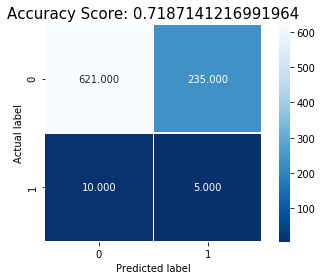

<Figure size 648x648 with 0 Axes>

In [68]:
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.title('Accuracy Score: {0}'.format(score), size = 15);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.figure(figsize=(9,9))

In [74]:
print('The accuracy rate is', round(score,1))

The accuracy rate is 0.7
